# Towards FFT based filter
Data example from https://www.fatiando.org/harmonica/latest/gallery/eql/harmonic.html#sphx-glr-gallery-eql-harmonic-py

In [1]:
%matplotlib inline


# Gridding and upward continuation

Most potential field surveys gather data along scattered and uneven flight
lines or ground measurements. For a great number of applications we may need to
interpolate these data points onto a regular grid at a constant altitude.
Upward-continuation is also a routine task for smoothing, noise attenuation,
source separation, etc.

Both tasks can be done simultaneously through an *equivalent layer*
[Dampney1969]_. We will use :class:`harmonica.EQLHarmonic` to estimate the
coefficients of a set of point sources (the equivalent layer) that fit the
observed data. The fitted layer can then be used to predict data values
wherever we want, like on a grid at a certain altitude. The sources for
:class:`~harmonica.EQLHarmonic` in particular are placed one beneath each data
point at a constant relative depth from the elevation of the data point
following [Cooper2000]_.

The advantage of using an equivalent layer is that it takes into account the 3D
nature of the observations, not just their horizontal positions. It also allows
data uncertainty to be taken into account and noise to be suppressed though the
least-squares fitting process. The main disadvantage is the increased
computational load (both in terms of time and memory).


C:\Users\22528618\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\22528618\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

Number of data points: 7054
Mean height of observations: 541.8293166997448


C:\Users\22528618\Anaconda3\envs\hm\lib\site-packages\numba\np\ufunc\parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


R² score: 0.9988789670714492

Generated grid:
 <xarray.Dataset>
Dimensions:           (easting: 80, northing: 131)
Coordinates:
  * easting           (easting) float64 -3.24e+05 -3.234e+05 ... -2.769e+05
  * northing          (northing) float64 4.175e+06 4.176e+06 ... 4.253e+06
    upward            (northing, easting) float64 1.5e+03 1.5e+03 ... 1.5e+03
Data variables:
    magnetic_anomaly  (northing, easting) float64 30.67 30.74 ... 163.5 149.9
Attributes:
    metadata:  Generated by EQLHarmonic(damping=1, parallel=True, points=None...


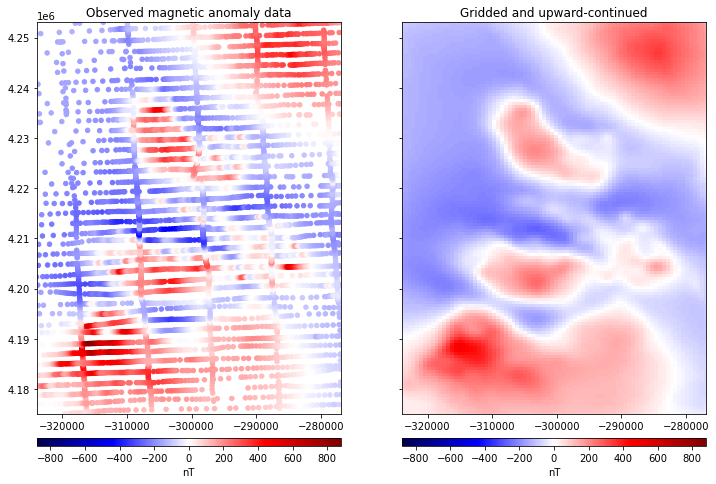

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import verde as vd
import harmonica as hm


# Fetch the sample total-field magnetic anomaly data from Great Britain
data = hm.datasets.fetch_britain_magnetic()

# Slice a smaller portion of the survey data to speed-up calculations for this
# example
region = [-5.5, -4.7, 57.8, 58.5]
inside = vd.inside((data.longitude, data.latitude), region)
data = data[inside]
print("Number of data points:", data.shape[0])
print("Mean height of observations:", data.altitude_m.mean())

# Since this is a small area, we'll project our data and use Cartesian
# coordinates
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = (easting, northing, data.altitude_m)

# Create the equivalent layer. We'll use the default point source configuration
# at a constant relative depth beneath each observation point. The damping
# parameter helps smooth the predicted data and ensure stability.
eql = hm.EQLHarmonic(relative_depth=1000, damping=1)

# Fit the layer coefficients to the observed magnetic anomaly.
eql.fit(coordinates, data.total_field_anomaly_nt)

# Evaluate the data fit by calculating an R² score against the observed data.
# This is a measure of how well layer the fits the data NOT how good the
# interpolation will be.
print("R² score:", eql.score(coordinates, data.total_field_anomaly_nt))

# Interpolate data on a regular grid with 500 m spacing. The interpolation
# requires the height of the grid points (upward coordinate). By passing in
# 1500 m, we're effectively upward-continuing the data (mean flight height is
# 500 m).
grid = eql.grid(upward=1500, spacing=600, data_names=["magnetic_anomaly"])

# The grid is a xarray.Dataset with values, coordinates, and metadata
print("\nGenerated grid:\n", grid)

# Plot original magnetic anomaly and the gridded and upward-continued version
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9), sharey=True)

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
maxabs = vd.maxabs(data.total_field_anomaly_nt, grid.magnetic_anomaly.values)

ax1.set_title("Observed magnetic anomaly data")
tmp = ax1.scatter(
    easting,
    northing,
    c=data.total_field_anomaly_nt,
    s=20,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax1, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax1.set_xlim(easting.min(), easting.max())
ax1.set_ylim(northing.min(), northing.max())

ax2.set_title("Gridded and upward-continued")
tmp = grid.magnetic_anomaly.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax2, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax2.set_xlim(easting.min(), easting.max())
ax2.set_ylim(northing.min(), northing.max())

plt.show()

# Check the performance of XRFT: Difference between xrft.fft and xrft.dft

(-38986.14768562156, 38986.14768562156)

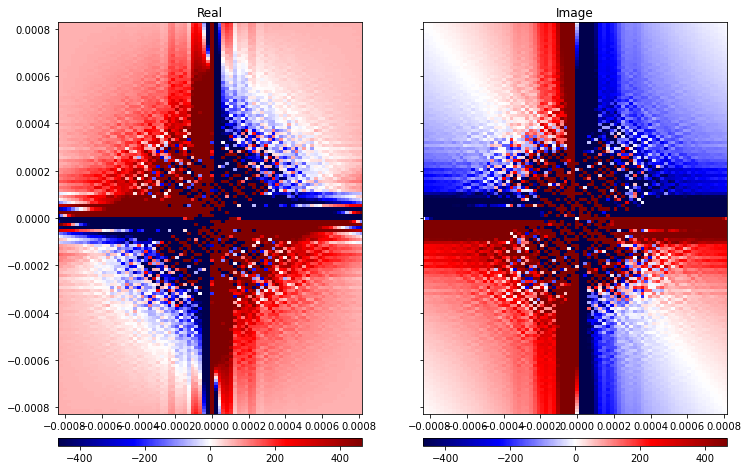

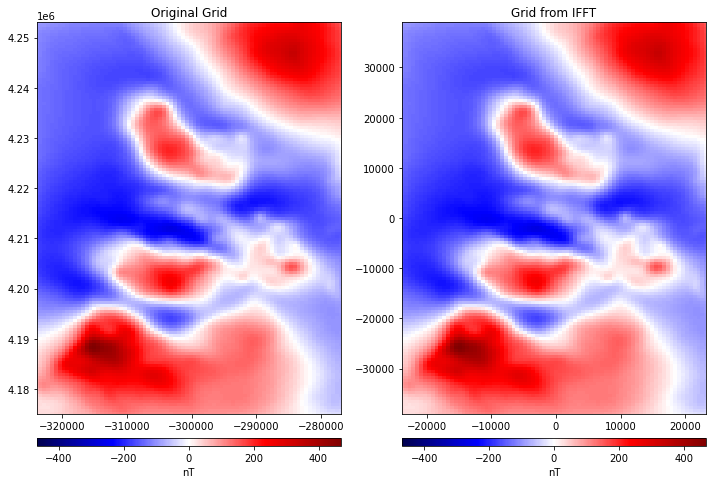

In [3]:
import xrft

#Do FFT transform
da_fft = xrft.fft(grid.magnetic_anomaly)
ida_fft = xrft.ifft(da_fft)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9), sharey=True)

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
maxabs = vd.maxabs(grid.magnetic_anomaly.values)

ax1.set_title("Real")
tmp1 = da_fft.real.plot.pcolormesh(
    ax=ax1,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp1, ax=ax1, pad=0.05, aspect=40, orientation="horizontal")
ax1.set_xlim(da_fft.freq_easting.min(), da_fft.freq_easting.max())
ax1.set_ylim(da_fft.freq_northing.min(), da_fft.freq_northing.max())

ax2.set_title("Image")
tmp2 = da_fft.imag.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp2, ax=ax2, pad=0.05, aspect=40, orientation="horizontal")
ax2.set_xlim(da_fft.freq_easting.min(), da_fft.freq_easting.max())
ax2.set_ylim(da_fft.freq_northing.min(), da_fft.freq_northing.max())

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
maxabs = vd.maxabs(grid.magnetic_anomaly.values, ida_fft.real.values)

ax1.set_title("Original Grid")
tmp = grid.magnetic_anomaly.plot.pcolormesh(
    ax=ax1,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax1, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax1.set_xlim(grid.easting.min(), grid.easting.max())
ax1.set_ylim(grid.northing.min(), grid.northing.max())

ax2.set_title("Grid from IFFT")
tmp2 = ida_fft.real.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp2, ax=ax2, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax2.set_xlim(ida_fft.easting.min(), ida_fft.easting.max())
ax2.set_ylim(ida_fft.northing.min(), ida_fft.northing.max())


## Let's check the difference of coordinate system between original and the grid from IFFT
The xrft will assume the center grid point with 0 coordinate, so we need add the original grid value back

For the cordinate with even number, old_cordinate = new_cordinate + mean(old_cordinate) + 0.5* spacing(new_cordinate)

For the cordinate with odd number, old_cordinate = new_cordinate + mean(old_cordinate)


In [4]:
# easting with 80 points
print("\nMean grid value:\n", grid.easting.mean())
print("\nOriginal Easting:\n", grid.easting)
print("\nIFFT Easting:\n",ida_fft.easting)
BackEasting=ida_fft.easting+grid.easting.mean()+0.5*ida_fft.easting.spacing
print("\nRestore Easting:\n",BackEasting)

# northing with 131 points
print("\nMean grid value:\n", grid.northing.mean())
print("\nOriginal Northing:\n", grid.northing)
print("\nIFFT Northing:\n",ida_fft.northing)
BackNorthing=ida_fft.northing+grid.northing.mean()
print("\nRestore Northing:\n",BackNorthing)



Mean grid value:
 <xarray.DataArray 'easting' ()>
array(-300446.203809)

Original Easting:
 <xarray.DataArray 'easting' (easting: 80)>
array([-324002.139135, -323405.786342, -322809.433549, -322213.080756,
       -321616.727963, -321020.37517 , -320424.022377, -319827.669584,
       -319231.316791, -318634.963997, -318038.611204, -317442.258411,
       -316845.905618, -316249.552825, -315653.200032, -315056.847239,
       -314460.494446, -313864.141653, -313267.78886 , -312671.436067,
       -312075.083274, -311478.730481, -310882.377688, -310286.024895,
       -309689.672102, -309093.319308, -308496.966515, -307900.613722,
       -307304.260929, -306707.908136, -306111.555343, -305515.20255 ,
       -304918.849757, -304322.496964, -303726.144171, -303129.791378,
       -302533.438585, -301937.085792, -301340.732999, -300744.380206,
       -300148.027412, -299551.674619, -298955.321826, -298358.969033,
       -297762.61624 , -297166.263447, -296569.910654, -295973.557861,
       -2953

In [5]:
#Check the wavenumber
#Spacing equal to 1/total
print("\nWavenumber Easting:\n",da_fft.freq_easting)
print("\nWavenumber Northing:\n",da_fft.freq_northing)


Wavenumber Easting:
 <xarray.DataArray 'freq_easting' (freq_easting: 80)>
array([-8.384299e-04, -8.174691e-04, -7.965084e-04, -7.755476e-04,
       -7.545869e-04, -7.336261e-04, -7.126654e-04, -6.917046e-04,
       -6.707439e-04, -6.497832e-04, -6.288224e-04, -6.078617e-04,
       -5.869009e-04, -5.659402e-04, -5.449794e-04, -5.240187e-04,
       -5.030579e-04, -4.820972e-04, -4.611364e-04, -4.401757e-04,
       -4.192149e-04, -3.982542e-04, -3.772934e-04, -3.563327e-04,
       -3.353720e-04, -3.144112e-04, -2.934505e-04, -2.724897e-04,
       -2.515290e-04, -2.305682e-04, -2.096075e-04, -1.886467e-04,
       -1.676860e-04, -1.467252e-04, -1.257645e-04, -1.048037e-04,
       -8.384299e-05, -6.288224e-05, -4.192149e-05, -2.096075e-05,
        0.000000e+00,  2.096075e-05,  4.192149e-05,  6.288224e-05,
        8.384299e-05,  1.048037e-04,  1.257645e-04,  1.467252e-04,
        1.676860e-04,  1.886467e-04,  2.096075e-04,  2.305682e-04,
        2.515290e-04,  2.724897e-04,  2.934505e-04,  3

# DFT 
Note the shift coordinate, and also the wrong amplitude for the idft 

C:\Users\22528618\Anaconda3\envs\hm\lib\site-packages\xrft\xrft.py:260: UserWarning: true_phase argument is ignored in xrft.ifft
  warnings.warn("true_phase argument is ignored in xrft.ifft")
C:\Users\22528618\Anaconda3\envs\hm\lib\site-packages\xrft\xrft.py:262: UserWarning: true_amplitude argument is ignored in xrft.ifft
  warnings.warn("true_amplitude argument is ignored in xrft.ifft")


(-38986.14768562156, 38986.14768562156)

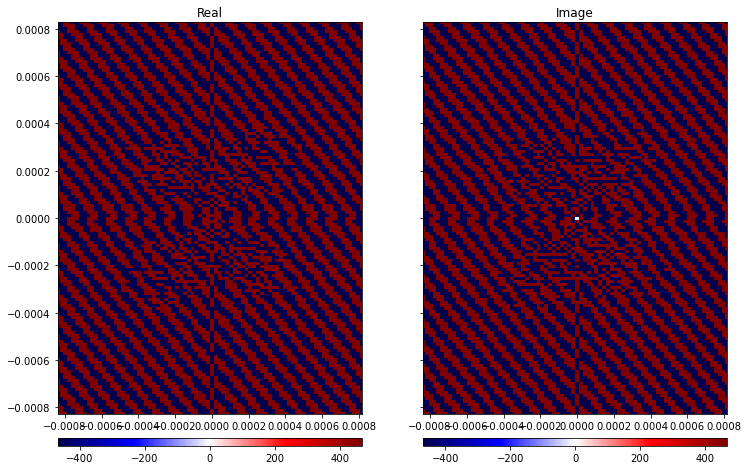

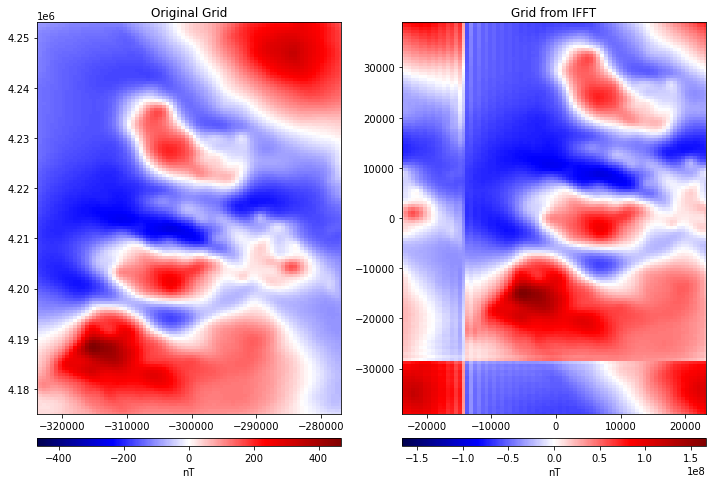

In [6]:
#DFT is a bit mess..
da_dft = xrft.dft(grid.magnetic_anomaly, true_phase=True, true_amplitude=True)
ida_dft = xrft.ifft(da_dft,true_phase=True, true_amplitude=True)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9), sharey=True)

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
maxabs = vd.maxabs(grid.magnetic_anomaly.values)

ax1.set_title("Real")
tmp1 = da_dft.real.plot.pcolormesh(
    ax=ax1,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp1, ax=ax1, pad=0.05, aspect=40, orientation="horizontal")
ax1.set_xlim(da_dft.freq_easting.min(), da_dft.freq_easting.max())
ax1.set_ylim(da_dft.freq_northing.min(), da_dft.freq_northing.max())

ax2.set_title("Image")
tmp2 = da_dft.imag.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp2, ax=ax2, pad=0.05, aspect=40, orientation="horizontal")
ax2.set_xlim(da_dft.freq_easting.min(), da_fft.freq_easting.max())
ax2.set_ylim(da_dft.freq_northing.min(), da_fft.freq_northing.max())

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
maxabs1 = vd.maxabs(grid.magnetic_anomaly.values)
maxabs2 = vd.maxabs(ida_dft.real.values)

ax1.set_title("Original Grid")
tmp1 = grid.magnetic_anomaly.plot.pcolormesh(
    ax=ax1,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs1,
    vmax=maxabs1,
    cmap="seismic",
)
plt.colorbar(tmp1, ax=ax1, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax1.set_xlim(grid.easting.min(), grid.easting.max())
ax1.set_ylim(grid.northing.min(), grid.northing.max())

ax2.set_title("Grid from IFFT")
tmp2 = ida_dft.real.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs2,
    vmax=maxabs2,
    cmap="seismic",
)
plt.colorbar(tmp2, ax=ax2, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax2.set_xlim(ida_dft.easting.min(), ida_dft.easting.max())
ax2.set_ylim(ida_dft.northing.min(), ida_dft.northing.max())


C:\Users\22528618\Anaconda3\envs\hm\lib\site-packages\xrft\xrft.py:260: UserWarning: true_phase argument is ignored in xrft.ifft
  warnings.warn("true_phase argument is ignored in xrft.ifft")
C:\Users\22528618\Anaconda3\envs\hm\lib\site-packages\xrft\xrft.py:262: UserWarning: true_amplitude argument is ignored in xrft.ifft
  warnings.warn("true_amplitude argument is ignored in xrft.ifft")


(-38986.14768562156, 38986.14768562156)

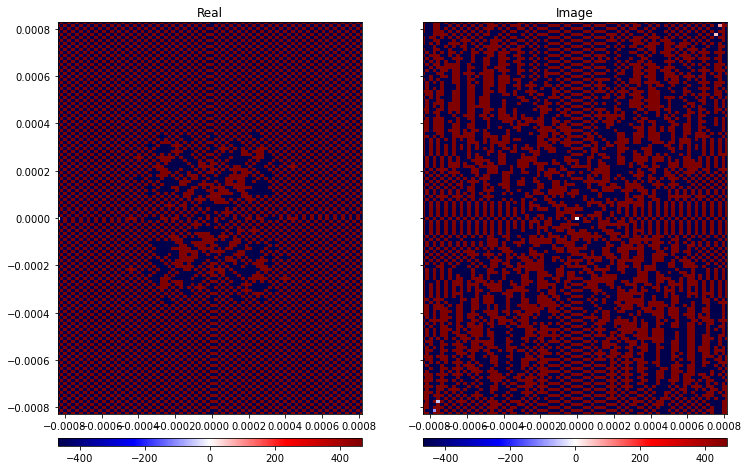

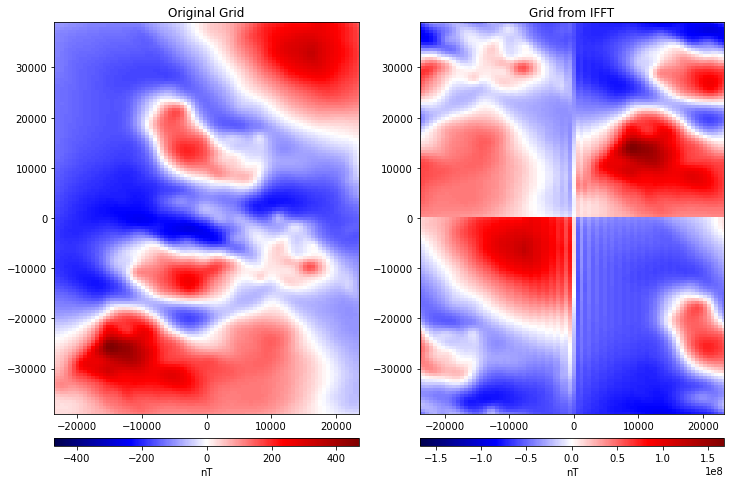

In [7]:
#We can change the coordinate and then perform the dft and ifft
Test=grid

#Remove mean
NewEasting=(Test.easting-Test.easting.mean())
NewNorthing=(Test.northing-Test.northing.mean())

#Assign new value
Test["easting"]=NewEasting
Test["northing"]=NewNorthing

test_dft = xrft.dft(Test.magnetic_anomaly, true_phase=True, true_amplitude=True)
itest_dft = xrft.ifft(test_dft,true_phase=True, true_amplitude=True)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9), sharey=True)

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
maxabs = vd.maxabs(grid.magnetic_anomaly.values)

ax1.set_title("Real")
tmp1 = test_dft.real.plot.pcolormesh(
    ax=ax1,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp1, ax=ax1, pad=0.05, aspect=40, orientation="horizontal")
ax1.set_xlim(test_dft.freq_easting.min(), test_dft.freq_easting.max())
ax1.set_ylim(test_dft.freq_northing.min(), test_dft.freq_northing.max())

ax2.set_title("Image")
tmp2 = test_dft.imag.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp2, ax=ax2, pad=0.05, aspect=40, orientation="horizontal")
ax2.set_xlim(test_dft.freq_easting.min(), test_dft.freq_easting.max())
ax2.set_ylim(test_dft.freq_northing.min(), test_dft.freq_northing.max())

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
maxabs1 = vd.maxabs(grid.magnetic_anomaly.values)
maxabs2 = vd.maxabs(itest_dft.real.values)

ax1.set_title("Original Grid")
tmp1 = grid.magnetic_anomaly.plot.pcolormesh(
    ax=ax1,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs1,
    vmax=maxabs1,
    cmap="seismic",
)
plt.colorbar(tmp1, ax=ax1, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax1.set_xlim(grid.easting.min(), grid.easting.max())
ax1.set_ylim(grid.northing.min(), grid.northing.max())

ax2.set_title("Grid from IFFT")
tmp2 = itest_dft.real.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs2,
    vmax=maxabs2,
    cmap="seismic",
)
plt.colorbar(tmp2, ax=ax2, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax2.set_xlim(itest_dft.easting.min(), itest_dft.easting.max())
ax2.set_ylim(itest_dft.northing.min(), itest_dft.northing.max())


#### Quicknote
So, I think we could just ignore the DFT function in xrft...

### Workflow...

###### Padding

Original grid --> save coordinate_o

Padding --> index for padding area

###### Core of filter
xrft.fft --> Define filter --> Apply filter --> xrft.ifft

###### Restore

Remove Padding area use index

Restore coordinate by restore coordinate_o
